# Text Classification with BERT
BERT (Bidirectional Encoder Representations from Transformers) is a recent [paper](https://arxiv.org/pdf/1810.04805.pdf) published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others.  
BERT is based on the Transformer architecture. To know more about Transformer, please refer this amazing [blog](http://jalammar.github.io/illustrated-transformer/)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### Install Dependencies

In [2]:
!pip install bert-tensorflow
!pip install tqdm
!pip install tensorflow_hub

     |████████████████████████████████| 71kB 4.6MB/s 


In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tf_hub
import time
import numpy as np
import os
from bert.tokenization import FullTokenizer
import tqdm
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

tf.logging.set_verbosity(tf.logging.INFO)
SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)

%matplotlib inline

In [4]:
print(tf.__version__)
print(tf_hub.__version__)

1.14.0
0.5.0


In [5]:
print(tf.test.is_gpu_available())
print(tf.test.gpu_device_name())

True
/device:GPU:0


### Load the Dataset
The dataset I have used is a small dataset containing only 10000 rows from the amazon fine reviews dataset. You can use the full dataset for training but it will require a huge amount of time.

In [9]:
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sample_amazon_reviews.csv')
dataset.head()

,Text,Sentiment
0,This food is the best. Our golden retriever w...,Positive
1,I finally found a jarred pasta sauce I love! B...,Positive
2,All the box of milk came intact. The taste of ...,Negative
3,This was the only treat my dog liked during ob...,Positive
4,I was very excited about this pasta. I have be...,Negative


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Text         10000 non-null object
Sentiment    10000 non-null object
dtypes: object(2)
memory usage: 156.3+ KB


In [11]:
dataset['Sentiment'] = [1 if sentiment == 'Positive' else 0 
                            for sentiment in dataset['Sentiment'].values]
dataset.head()

,Text,Sentiment
0,This food is the best. Our golden retriever w...,1
1,I finally found a jarred pasta sauce I love! B...,1
2,All the box of milk came intact. The taste of ...,0
3,This was the only treat my dog liked during ob...,1
4,I was very excited about this pasta. I have be...,0


In [12]:
train_df = dataset.iloc[:8000]
val_df = dataset.iloc[8000:9000]
test_df = dataset.iloc[9000:]

train_df.shape, val_df.shape, test_df.shape

((8000, 2), (1000, 2), (1000, 2))

In [0]:
train_text = train_df['Text'].tolist()
train_labels = train_df['Sentiment'].tolist()

val_text = val_df['Text'].tolist()
val_labels = val_df['Sentiment'].tolist()

test_text = test_df['Text'].tolist()
test_labels = test_df['Sentiment'].tolist()

### BERT Data Preparation

In [0]:
class PaddingInputExample(object):
  pass
    
    
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [0]:
def create_tokenizer_from_hub_module(bert_path):
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  tf_hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

In [0]:
def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=text, text_b=None, label=label)
        )
    return InputExamples

In [0]:
def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)
    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

In [0]:
def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm.tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

In [0]:
# Initialize session
sess = tf.Session()

# Params for bert model and tokenization
BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
MAX_SEQ_LENGTH = 512

In [21]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module(bert_path=BERT_PATH)

I0824 16:55:37.982342 140297130354560 saver.py:1499] Saver not created because there are no variables in the graph to restore
W0824 16:55:39.835515 140297130354560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [0]:
# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_labels)
val_examples = convert_text_to_examples(val_text, val_labels)
test_examples = convert_text_to_examples(test_text, test_labels)

In [23]:
(train_input_ids, train_input_masks, 
 train_segment_ids, train_labels) =  convert_examples_to_features(tokenizer=tokenizer, 
                                                                  examples=train_examples, 
                                                                  max_seq_length=MAX_SEQ_LENGTH)

(val_input_ids, val_input_masks, 
 val_segment_ids, val_labels) =  convert_examples_to_features(tokenizer=tokenizer, 
                                                              examples=val_examples, 
                                                              max_seq_length=MAX_SEQ_LENGTH)

(test_input_ids, test_input_masks, 
 test_segment_ids, test_labels) =  convert_examples_to_features(tokenizer=tokenizer, 
                                                                examples=test_examples, 
                                                                max_seq_length=MAX_SEQ_LENGTH)

Converting examples to features: 100%|██████████| 1000/1000 [00:01<00:00, 788.91it/s]


In [24]:
train_input_ids.shape, val_input_ids.shape, test_input_ids.shape

((8000, 512), (1000, 512), (1000, 512))

In [25]:
bm = tf_hub.Module(BERT_PATH, trainable=True, name=f"bert_module")
bm

### Build BERT Model for Text Classification

In [0]:
class BertLayer(tf.keras.layers.Layer):
    
    def __init__(self, bert_path, n_fine_tune_encoders=10, **kwargs,):
        
        self.n_fine_tune_encoders = n_fine_tune_encoders
        self.trainable = True
        self.output_size = 768
        self.bert_path = bert_path
        super(BertLayer, self).__init__(**kwargs)

        
    def build(self, input_shape):
        self.bert = tf_hub.Module(self.bert_path,
                                  trainable=self.trainable, 
                                  name=f"{self.name}_module")

        # Remove unused layers
        trainable_vars = self.bert.variables
        trainable_vars = [var for var in trainable_vars 
                                  if not "/cls/" in var.name]
        trainable_layers = ["embeddings", "pooler/dense"]


        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_encoders+1):
            trainable_layers.append(f"encoder/layer_{str(10 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [var for var in trainable_vars
                                  if any([l in var.name 
                                              for l in trainable_layers])]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:# and 'encoder/layer' not in var.name:
                self._non_trainable_weights.append(var)
        print('Trainable layers:', len(self._trainable_weights))
        print('Non Trainable layers:', len(self._non_trainable_weights))

        super(BertLayer, self).build(input_shape)
        
    def call(self, inputs):
        
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(input_ids=input_ids, 
                           input_mask=input_mask, 
                           segment_ids=segment_ids)
        
        pooled = self.bert(inputs=bert_inputs, 
                           signature="tokens", 
                           as_dict=True)["pooled_output"]

        return pooled

    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [0]:
# Build model
def build_model(bert_path, max_seq_length, n_fine_tune_encoders=10): 
    
    inp_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    inp_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    inp_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [inp_id, inp_mask, inp_segment]
    
    bert_output = BertLayer(bert_path=bert_path, 
                            n_fine_tune_encoders=n_fine_tune_encoders)(bert_inputs)
    
    dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(lr=2e-5), 
                  metrics=['accuracy'])    
    return model

In [0]:
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [29]:
model = build_model(bert_path=BERT_PATH, max_seq_length=MAX_SEQ_LENGTH, n_fine_tune_encoders=10)

initialize_vars(sess)

Trainable layers: 199
Non Trainable layers: 5


I0824 17:02:44.192648 140297130354560 saver.py:1499] Saver not created because there are no variables in the graph to restore
W0824 17:02:49.166233 140297130354560 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0824 17:02:49.224421 140297130354560 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]            

### Train the Model

In [32]:
model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels),
    epochs=2,
    batch_size=8,
    verbose=1
)

Train on 8000 samples, validate on 1000 samples
Epoch 1/2
8000/8000 [==============================] - 994s 124ms/sample - loss: 0.3102 - acc: 0.8643 - val_loss: 0.2486 - val_acc: 0.9100
Epoch 2/2
8000/8000 [==============================] - 991s 124ms/sample - loss: 0.1235 - acc: 0.9585 - val_loss: 0.2607 - val_acc: 0.8910


### Evaluate the model on TEST Dataset

In [33]:
test_predictions = model.predict(x=[test_input_ids, 
                                    test_input_masks, 
                                    test_segment_ids],
                                 batch_size=64,
                                 verbose=1)

1000/1000 [==============================] - 46s 46ms/sample


In [0]:
test_predictions = test_predictions.ravel()
test_pred_labels = [1 if prob > 0.5 else 0 for prob in test_predictions]

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report:')
print(classification_report(y_true=test_labels, y_pred=test_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       493
           1       0.93      0.87      0.90       507

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



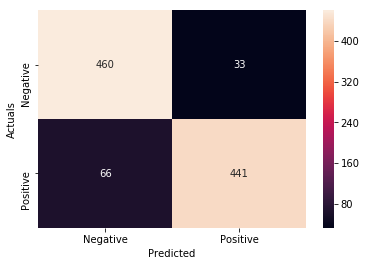

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

with tf.Session() as session:
    cm = tf.confusion_matrix(test_labels, test_pred_labels).eval()

LABELS = ['Negative', 'Positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")